In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [2]:
def read_img(path):
    img = Image.open(path)
    img = img.resize((128,128))
#     img.show()
    img_data = np.asarray(img)
    return img_data


In [3]:
img = read_img("face_detect_dataset\\s1\\1.pgm")
print(img.shape)
img = img[::2,::2]
print(img.shape)

(128, 128)
(64, 64)


In [4]:
def get_data(sample_size):
    img = read_img("face_detect_dataset\\s1\\1.pgm")
    img = img[::2,::2]
    dim1 = img.shape[0]
    dim2 = img.shape[1]
    count = 0
    img_pairs_same = np.zeros([sample_size,2,dim1,dim2,1])
    img_labels_same = np.zeros([sample_size,1])
    
    for i in range(40):
        for j in range(sample_size//40):
            ind1 = 0
            ind2 = 0
            while(ind1 == ind2):
                ind1 = np.random.randint(10)
                ind2 = np.random.randint(10)
            img1 = read_img("face_detect_dataset\\s" + str(i+1) + "\\" + str(ind1+1) + ".pgm")
            img2 = read_img("face_detect_dataset\\s" + str(i+1) + "\\" + str(ind2+1) + ".pgm")
            img1 = img1[::2,::2]
            img2 = img2[::2,::2]
            img_pairs_same[count,0,:,:,0] = img1
            img_pairs_same[count,1,:,:,0] = img2
            img_labels_same[count] = 1
            count = count+1
            
    count = 0
    img_pairs_diff = np.zeros([sample_size,2,dim1,dim2,1])
    img_labels_diff = np.zeros([sample_size,1])
    
    for i in range(sample_size//10):
        for j in range(10):
            ind1 = 0
            ind2 = 0
            while(ind1 == ind2):
                ind1 = np.random.randint(40)
                ind2 = np.random.randint(40)
            img1 = read_img("face_detect_dataset\\s" + str(ind1+1) + "\\" + str(j+1) + ".pgm")
            img2 = read_img("face_detect_dataset\\s" + str(ind2+1) + "\\" + str(j+1) + ".pgm")
            img1 = img1[::2,::2]
            img2 = img2[::2,::2]
            img_pairs_diff[count,0,:,:,0] = img1
            img_pairs_diff[count,1,:,:,0] = img2
            img_labels_diff[count] = 0;
            count = count + 1
            
    X = np.concatenate([img_pairs_same,img_pairs_diff],axis = 0)/255
    Y = np.concatenate([img_labels_same,img_labels_diff],axis = 0)
    
    return X,Y

In [5]:
sample_size = 10000
X,Y = get_data(sample_size)
X,Y = shuffle(X,Y)
print(X.shape)
print(Y.shape)

(20000, 2, 64, 64, 1)
(20000, 1)


In [6]:
print(Y[0])
print(Y[1])
print(Y[2])
print(Y[3])
img_train,img_test,label_train,label_test = train_test_split(X,Y,test_size = .20)
print(img_train.shape)
print(label_train.shape)

[0.]
[1.]
[1.]
[1.]
(16000, 2, 64, 64, 1)
(16000, 1)


In [2]:
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,Dropout,Input,Lambda
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K 

In [3]:
def build_convNet(input_shape):
    model = Sequential([
        Conv2D(16,(3,3),input_shape = input_shape,activation = "relu",name = "conv_1"),
        MaxPooling2D((3,3),name = "maxpool_1"),
#         Dropout(.10),
        Conv2D(32,(3,3),activation = "relu",name = "conv_2"),
        MaxPooling2D((3,3),name = "maxpool_2"),
#         Dropout(.10),
        Flatten(),
        Dense(128,activation = "relu")
    ])
    return model

In [4]:
input_shape = (64,64,1)
img_a = Input(shape = input_shape)
img_b = Input(shape = input_shape)
convNet = build_convNet(input_shape)
convNet.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 62, 62, 16)        160       
_________________________________________________________________
maxpool_1 (MaxPooling2D)     (None, 20, 20, 16)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 18, 18, 32)        4640      
_________________________________________________________________
maxpool_2 (MaxPooling2D)     (None, 6, 6, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               147584    
Total params: 152,384
Trainable params: 152,384
Non-trainable params: 0
__________________________________________________

In [5]:
encode_a = convNet(img_a)
encode_b = convNet(img_b)

In [6]:
def dist(encodings):
    a,b = encodings
    d = K.sqrt(K.sum(K.square(a - b),axis = 1,keepdims = True))
    return d

def dist_out_shape(shapes):
#     shape1,shape2 = shapes
    return (shapes[0],1)

distance = Lambda(dist,output_shape = dist_out_shape)([encode_a,encode_b])

In [7]:
epochs = 16
optim = Adam(learning_rate = 0.001)
model = Model(inputs = [img_a,img_b],outputs = distance)

In [8]:
def loss_fn(y_true,y_pred):
    margin = 0.7
    return K.mean(y_true*K.square(y_pred) + (1-y_true)*K.square(K.maximum(margin-y_pred,0)))

In [9]:
model.compile(loss = loss_fn,optimizer = optim)

In [15]:
img_1 = img_train[:,0]
img_2 = img_train[:,1]
history = model.fit([img_1,img_2],label_train,validation_split = 0.25,batch_size = 64,epochs = epochs,verbose = 2)

Epoch 1/16
188/188 - 7s - loss: 0.0347 - val_loss: 0.0209
Epoch 2/16
188/188 - 6s - loss: 0.0141 - val_loss: 0.0098
Epoch 3/16
188/188 - 6s - loss: 0.0070 - val_loss: 0.0054
Epoch 4/16
188/188 - 6s - loss: 0.0040 - val_loss: 0.0029
Epoch 5/16
188/188 - 6s - loss: 0.0026 - val_loss: 0.0017
Epoch 6/16
188/188 - 6s - loss: 0.0015 - val_loss: 0.0014
Epoch 7/16
188/188 - 6s - loss: 9.8545e-04 - val_loss: 7.1474e-04
Epoch 8/16
188/188 - 6s - loss: 6.8374e-04 - val_loss: 5.0549e-04
Epoch 9/16
188/188 - 6s - loss: 5.4233e-04 - val_loss: 5.2233e-04
Epoch 10/16
188/188 - 6s - loss: 4.1509e-04 - val_loss: 3.9321e-04
Epoch 11/16
188/188 - 6s - loss: 3.3738e-04 - val_loss: 4.6503e-04
Epoch 12/16
188/188 - 6s - loss: 3.5141e-04 - val_loss: 5.8296e-04
Epoch 13/16
188/188 - 6s - loss: 3.4720e-04 - val_loss: 1.8668e-04
Epoch 14/16
188/188 - 6s - loss: 1.5606e-04 - val_loss: 1.7475e-04
Epoch 15/16
188/188 - 6s - loss: 3.4923e-04 - val_loss: 6.0155e-04
Epoch 16/16
188/188 - 6s - loss: 4.5324e-04 - val_lo

In [16]:
pred = model.predict([img_test[:,0], img_test[:,1]])
print(pred)

[[1.2032942 ]
 [0.81683266]
 [0.01356017]
 ...
 [1.1726925 ]
 [1.6666901 ]
 [0.02008936]]


In [17]:
def get_accuracy(pred,labels,threshold):
    return labels[pred.ravel() < threshold].mean()

In [18]:
get_accuracy(pred, label_test,0.5)

1.0

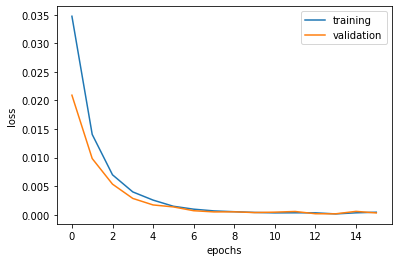

In [19]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.ylabel("loss")
plt.xlabel("epochs")
plt.legend(["training","validation"],loc = "upper right")
plt.show()

In [24]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [10]:
model.load_weights("chkpt/saved_weights")

In [11]:
from PIL import ImageOps

In [12]:
myimg1 = Image.open("Downloads\\mya1.jpeg")
myimg2 = Image.open("Downloads\\mya2.jpeg")
myimg1 = ImageOps.grayscale(myimg1)
myimg2 = ImageOps.grayscale(myimg2)
myimg1 = myimg1.resize((64,64))
myimg2 = myimg2.resize((64,64))  
inp_a = np.asarray(myimg1)/255
inp_b = np.asarray(myimg2)/255
myimg1.show()
myimg2.show()
pred = model.predict([inp_a[np.newaxis,...,np.newaxis], inp_b[np.newaxis,...,np.newaxis]])
print(pred)

UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node model/sequential/conv_1/Conv2D (defined at <ipython-input-12-61e0807558c2>:11) ]] [Op:__inference_predict_function_398]

Function call stack:
predict_function
